In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal,chisquare,chi2_contingency
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import funcs
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

In [26]:
data = pd.read_csv("../objects/df_imputed_not_complete_874.csv", index_col=0)
data.head()

,RID,PTHAND,PTMARRY,PTEDUCAT,PTNOTRT,PTHOME,PTPLANG,PTETHCAT,PTRACCAT,age,...,RCT29,RCT3,RCT392,RCT4,RCT5,RCT6,RCT8,RCT9,apoe,DIAGNOSIS
1,2,2,1,16,1,1,1,2,5,74.333333,...,0.2,19,1.1,21,19,15,5.6,3.0,2,Control
2,3,1,1,18,1,3,1,2,5,81.250000,...,0.1,21,1.3,16,19,19,6.9,3.5,3,AZ
3,4,1,1,10,0,1,2,1,5,67.583333,...,0.1,16,1.2,23,18,25,6.0,2.9,2,MCI
4,5,1,1,16,1,1,1,2,5,73.666667,...,0.2,16,1.0,17,24,14,5.7,3.2,2,Control
5,6,1,1,13,1,1,1,2,5,80.416667,...,0.2,19,1.1,16,19,23,5.3,4.5,2,MCI


In [28]:
data.drop(['RID'], axis = 1, inplace=True)

## Filter-based feature selection

### KW test for continuous vars & Kramer's V for categorical vars

In [30]:
cat_features = [col for col in data.columns if (
    col.startswith("NX") or
    col.startswith("PX") or
    col.startswith("PT") or
    col.startswith("MH") or
    (col.startswith("GD") and col != "GDTOTAL") or
    col in ["mother", "father", "HMSCORE", "apoe",]
)]

In [32]:
cont_features = [col for col in data.columns if 
                 col not in cat_features and 
                col != "DIAGNOSIS"]

In [39]:
kr_stat = []
kr_p = []
for f in cont_features:
    groups = [data[f][data['DIAGNOSIS'] == cat] for cat in data['DIAGNOSIS'].unique()]
    kruskal_result = kruskal(*groups)
    kr_stat.append(kruskal_result.statistic)
    kr_p.append(kruskal_result.pvalue)


In [42]:
result_kw = pd.DataFrame({"feature": cont_features,
                         "stat": kr_stat,
                         "pvalue": kr_p})

In [45]:
result_kw[result_kw['pvalue'] < 0.01]

,feature,stat,pvalue
1,weight,11.788305,2.755511e-03
2,height,9.727670,7.720817e-03
7,VSPULSE,13.438741,1.207298e-03
9,LIMMTOTAL,436.018627,2.088133e-95
10,LDELTOTAL,543.719714,8.565729e-119
11,GDTOTAL,68.551723,1.300716e-15
14,HMT100,14.056448,8.865047e-04
19,HMT15,25.316244,3.181614e-06
20,HMT16,18.727201,8.579063e-05
29,HMT8,16.293852,2.896242e-04


In [71]:
cont_features_sig = result_kw[result_kw['pvalue'] < 0.01].feature.tolist()

In [58]:
cr = []

for f in cat_features:
    cont_tab = pd.crosstab(index=data['DIAGNOSIS'], columns=data[f])
    chi2, p, dof, expected = chi2_contingency(cont_tab)
    n = cont_tab.sum().sum()
    phi2 = chi2 / n
    r, k = cont_tab.shape
    cramers_v = np.sqrt(phi2 / min(r-1, k-1))
    cr.append(cramers_v)

In [62]:
result_kramer = pd.DataFrame({"feature": cat_features,
                         "Kramer": cr})
result_kramer = result_kramer.sort_values(by="Kramer", ascending=False)

In [73]:
result_kramer[result_kramer['Kramer'] > 0.1]

,feature,Kramer
59,GDMEMORY,0.398052
66,apoe,0.218232
32,MHPSYCH,0.192215
2,PTEDUCAT,0.167799
51,GDDROP,0.153349
31,NXGAIT,0.150544
4,PTHOME,0.132056
64,GDBETTER,0.128134
53,GDBORED,0.127018
63,GDHOPE,0.104368


In [78]:
cat_features_sig = result_kramer[result_kramer['Kramer'] > 0.1].feature.tolist()

In [80]:
feat = cont_features_sig + cat_features_sig

### Model after feature selection

In [96]:
X, X_test, y, y_test = train_test_split(data[feat], outcome, test_size=0.2, random_state=43)

In [105]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [109]:
best_params_feat_selection = {"iterations": 1800, 
                              "learning_rate": 0.20649746303659136, 
                              "l2_leaf_reg": 4.37841702433753, 
                              "bagging_temperature": 1.6766419657563723, 
                              "random_strength": 1.9555985333019168, 
                              "depth": 7, 
                              "min_data_in_leaf": 91, 
                              'random_seed': 42,
                              'loss_function': "MultiClass",
                              "colsample_bylevel": 0.9759404466998405}

In [113]:
final_model = CatBoostClassifier(**best_params_feat_selection, verbose=False)

In [116]:
final_model.fit(X, y)

In [119]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [122]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.906977,0.812500,0.931818,0.968504,0.986258
1,MCI,0.783505,0.844444,0.820513,0.752941,0.900211
2,AD,0.714286,0.675676,0.914286,0.927536,0.923265


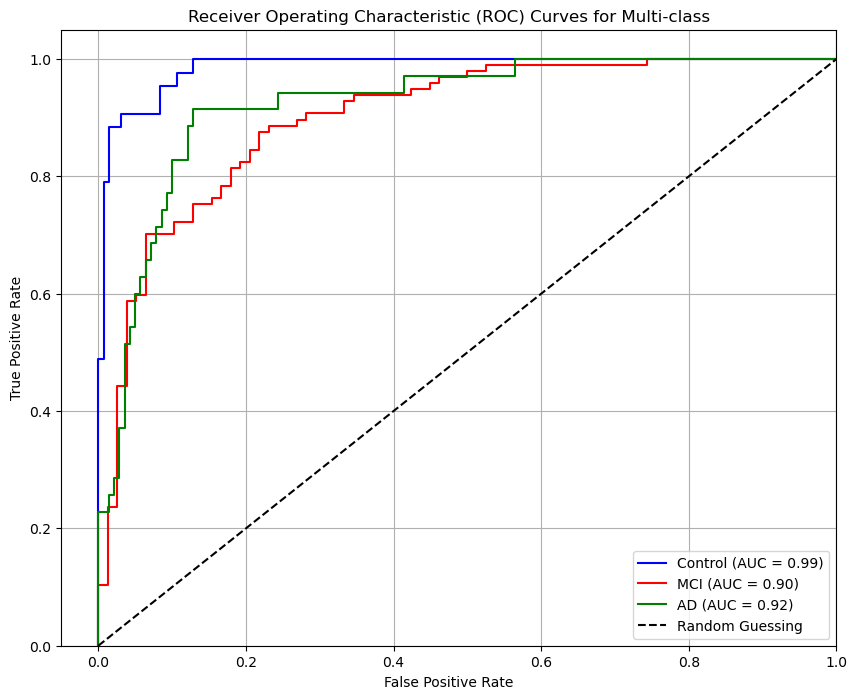

In [131]:
n_classes = len(np.unique(y_test))
class_labels = ["Control", "MCI", "AD"]
colors = ['blue', 'red', 'green']  # Define colors for the ROC curves

# Create a plot for ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test == i, predictions_proba[:, i])  # True binary labels for each class
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line for random guessing
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### PCA

In [138]:
data_feat = data[feat]
outcome = data['DIAGNOSIS']

In [144]:
pipeline = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2)),])

In [147]:
pca_data = pd.DataFrame(
    pipeline.fit_transform(data_feat),
    columns=["PC1", "PC2"],
    index=data_feat.index
)
pca_data['outcome'] = outcome
pca_step = pipeline.steps[1][1]

### MCI overlaps with both Control and AD

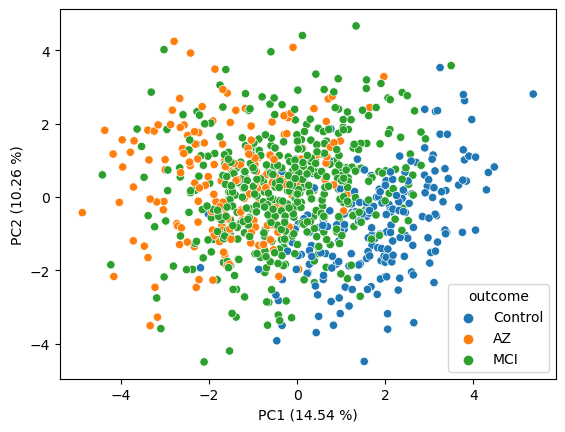

In [154]:
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2", hue="outcome")


# Add variance explained by the
g.set_xlabel(f"PC1 ({pca_step.explained_variance_ratio_[0]*100:.2f} %)")
g.set_ylabel(f"PC2 ({pca_step.explained_variance_ratio_[1]*100:.2f} %)")

#plt.savefig("PCA_with_loadings.tiff", dpi=300)
plt.show()

In [165]:
pca_MCI = pca_data[pca_data["outcome"] == "MCI"]

In [167]:
gmm = GaussianMixture(n_components=3, covariance_type='tied')
labels = gmm.fit_predict(pca_MCI.iloc[:,0:2])

D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [171]:
labels_MCI = np.where(labels == 0, "MCI1", np.where(labels == 1, "MCI2", "MCI3"))

In [173]:
pca_data["cluster"] = pca_data["outcome"]
pca_data.loc[pca_data["outcome"] == "MCI", "cluster"] = labels_MCI

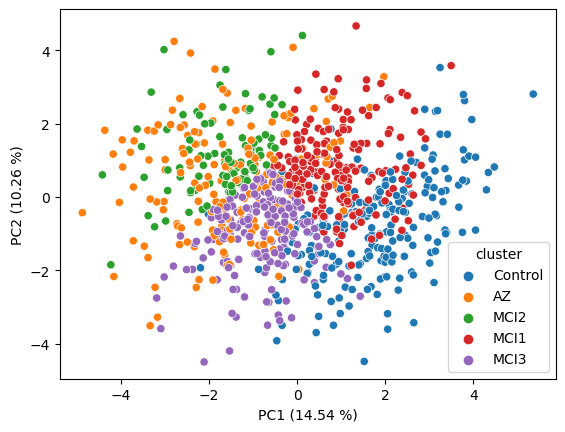

In [176]:
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2", hue="cluster")


# Add variance explained by the
g.set_xlabel(f"PC1 ({pca_step.explained_variance_ratio_[0]*100:.2f} %)")
g.set_ylabel(f"PC2 ({pca_step.explained_variance_ratio_[1]*100:.2f} %)")

#plt.savefig("PCA_with_loadings.png", dpi=200)
plt.show()

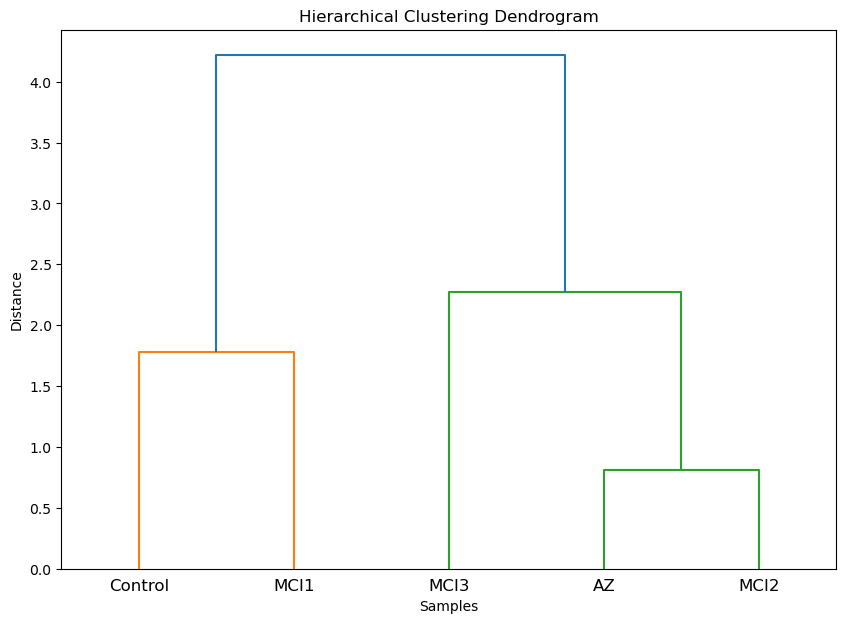

In [179]:
grouped_data = pca_data.groupby('cluster')[['PC1', 'PC2']].mean()
Z = linkage(grouped_data, method='ward')

# Create a dendrogram to visualize the clustering
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=grouped_data.index)  # 'outcome' includes AZ, Control, MCI1, MCI2, MCI3
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [183]:
data_feat_cluster = data_feat.copy()
data_feat_cluster["cluster"] = pca_data["cluster"]

In [189]:
data_feat_cluster['cluster'] = data_feat_cluster['cluster'].replace({'MCI1': 'MCI_Middle', 'MCI2':'MCI_AD', 'MCI3': 'MCI_Healthy'})

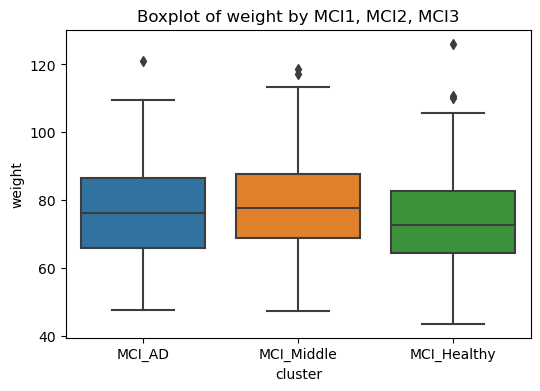

Kruskal-Wallis for weight: H = 11.160, p = 0.004


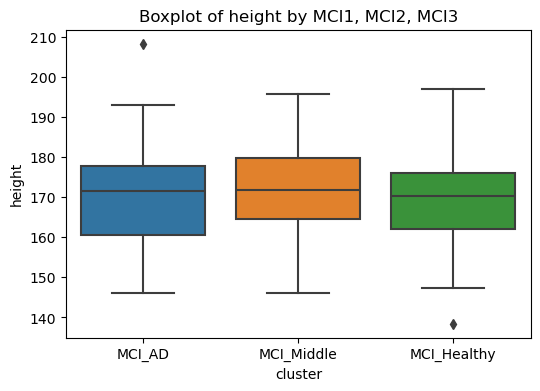

Kruskal-Wallis for height: H = 4.626, p = 0.099


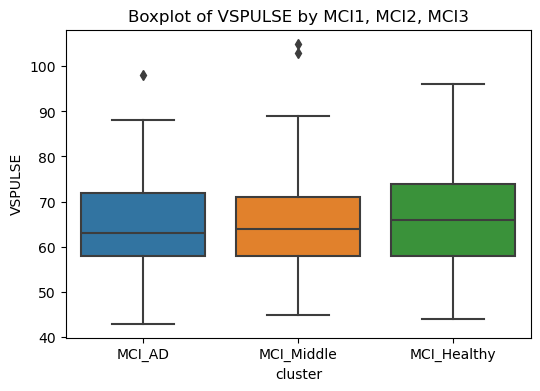

Kruskal-Wallis for VSPULSE: H = 2.927, p = 0.231


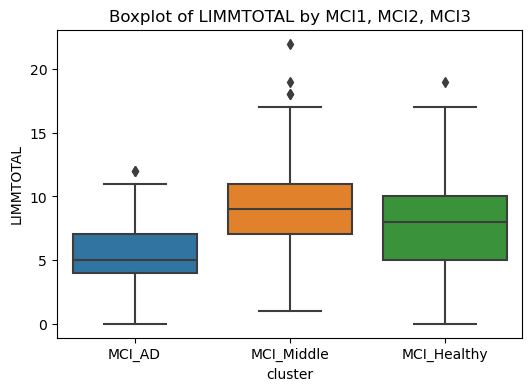

Kruskal-Wallis for LIMMTOTAL: H = 76.662, p = 0.000


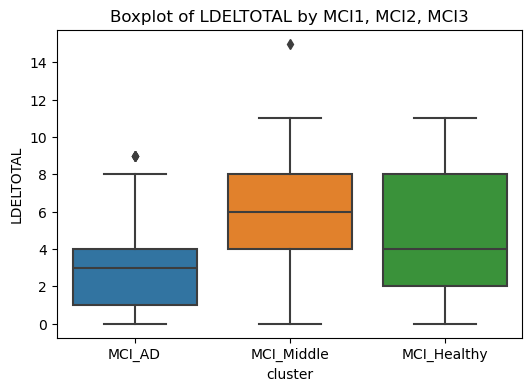

Kruskal-Wallis for LDELTOTAL: H = 65.742, p = 0.000


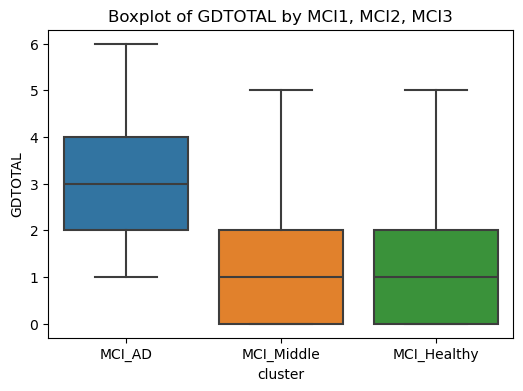

Kruskal-Wallis for GDTOTAL: H = 119.006, p = 0.000


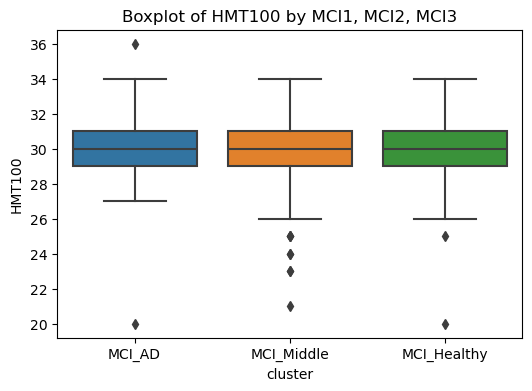

Kruskal-Wallis for HMT100: H = 0.558, p = 0.756


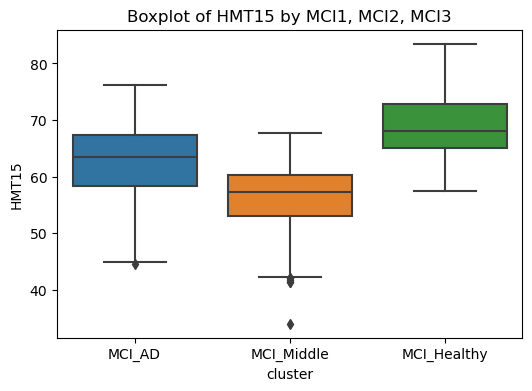

Kruskal-Wallis for HMT15: H = 259.537, p = 0.000


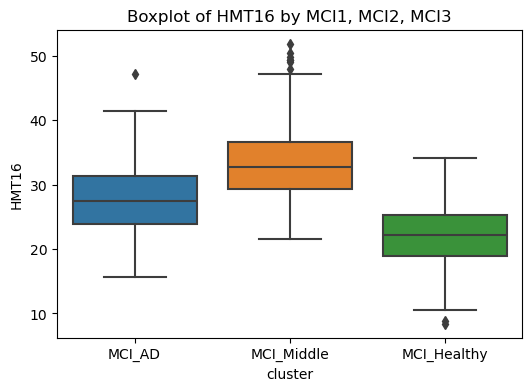

Kruskal-Wallis for HMT16: H = 252.976, p = 0.000


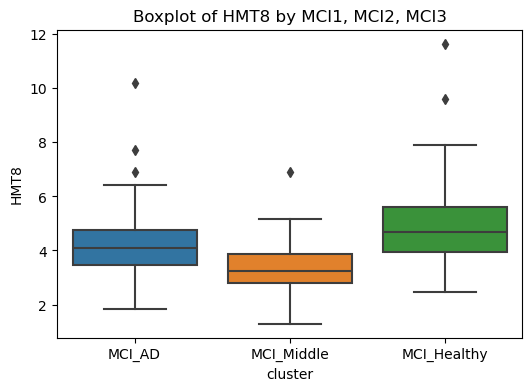

Kruskal-Wallis for HMT8: H = 154.441, p = 0.000


In [206]:
for var in cont_features_sig:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=var, data=data_feat_cluster)
    plt.title(f'Boxplot of {var} by MCI1, MCI2, MCI3')
    plt.show()

    # Perform statistical test (ANOVA or Kruskal-Wallis)
    mci1_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_Middle'][var]
    mci2_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_AD'][var]
    mci3_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_Healthy'][var]


    stat, p_value = kruskal(mci1_data, mci2_data, mci3_data)
    print(f"Kruskal-Wallis for {var}: H = {stat:.3f}, p = {p_value:.3f}")